Initial Test for Using the scikit-learn Library
===
Objectives:
* Familiarize to Python syntax;
* Familiarize to scikit-learn methods;
* Draft a dummy algorithm simulating the FDD system to be developed.
    * Using the mixture models in the scikit-learn library.
    * Using simulated data set.

In [2]:
# Author: Thiago Akio Nakamura
# E-mail: akionakas@gmail.com

# Import necessary classes and libraries
%matplotlib inline
import numpy
import matplotlib.pyplot
import time

from scipy import linalg
from sklearn.datasets import make_blobs
from sklearn import mixture

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cross_validation import train_test_split
from matplotlib.colors import LogNorm

Creating the Data
---
The first step is to generate the simulated data-set.

Created 2400 training samples.
Created 600 validation samples.


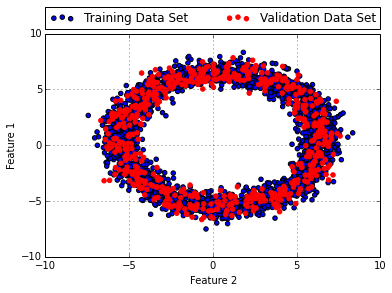

In [3]:
# Create the data
N = 3000 # number of data points
train_perct = 0.8
t = numpy.linspace(0, 4*numpy.pi, N)
feature1 = 6.0*numpy.sin(8*t+0.001) + 0.5 + 0.6*numpy.random.randn(N) # create artificial data with noise
feature2 = 6.0*numpy.cos(8*t+0.001) + 0.5 + 0.6*numpy.random.randn(N) # create artificial data with noise
X = numpy.vstack((feature1, feature2)).T
train_idxs = numpy.arange(int(numpy.round(train_perct*N)))
val_idxs = numpy.arange(int(numpy.round(train_perct*N)), N)

t_train = t[train_idxs]
t_val = t[val_idxs]
X_train = X[train_idxs, :]
X_val = X[val_idxs, :]

print 'Created {} training samples.'.format(len(t_train))
print 'Created {} validation samples.'.format(len(t_val))
matplotlib.pyplot.figure()
matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1])
matplotlib.pyplot.scatter(X_val[:, 0], X_val[:, 1], color='red')
matplotlib.pyplot.legend(['Training Data Set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.title('Data set')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

Lets us also see the data as a time-series.

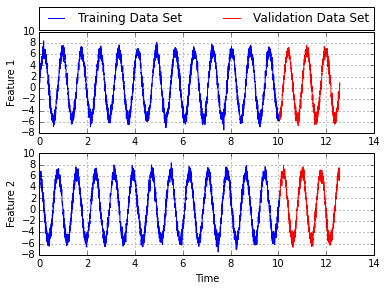

In [4]:
matplotlib.pyplot.figure()
matplotlib.pyplot.subplot(211)
matplotlib.pyplot.plot(t_train, X_train[:, 0])
matplotlib.pyplot.plot(t_val, X_val[:, 0], color='red')
matplotlib.pyplot.legend(['Training Data Set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.grid()
matplotlib.pyplot.subplot(212)
matplotlib.pyplot.plot(t_train, X_train[:, 1])
matplotlib.pyplot.plot(t_val, X_val[:, 1], color='red')
matplotlib.pyplot.ylabel('Feature 2')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

Several models can be trained. Here we select the number of components to cover and types of covariances. The resulting number of models to be trained is the product of those two.

In [5]:
# Modelling parameters
min_num_comp = 1
max_num_comp = 8
num_comps = numpy.arange(min_num_comp, max_num_comp+1)
# 'spherical', 'tied', 'diag', 'full'
covariance_types = ['full', 'diag', 'spherical', 'tied']
tol = 1e-3
max_it = 100
params = 'wmc'

print 'Models from {} to {} number of components will be trained'.format(min_num_comp, max_num_comp)
print 'The following covariance types will be testes: {}.'.format(covariance_types)
print 'Resulting in a total of {} models.'.format(len(max_num_comp*covariance_types))

Models from 1 to 8 number of components will be trained
The following covariance types will be testes: ['full', 'diag', 'spherical', 'tied'].
Resulting in a total of 32 models.


In [6]:
# Train models
models = []
i = 1

for cov_type_idx in range(len(covariance_types)):
    models.append([])
    for num_comp in num_comps:
        model = mixture.GMM(n_components=num_comp,
                            covariance_type=covariance_types[cov_type_idx],
                            tol=tol,
                            n_init=max_it,
                            params=params)
        print '{}) Start training model with {} components and {} covariance.'.format(i, num_comp, covariance_types[cov_type_idx])
        start = time.time()
        model.fit(X_train)
        models[cov_type_idx].append(model)
        i = i + 1
        end = time.time()
        print '     Model {}-{} trained in {} seconds.'.format(num_comp, covariance_types[cov_type_idx], end - start)
        

1) Start training model with 1 components and full covariance.
     Model 1-full trained in 1.41774106026 seconds.
2) Start training model with 2 components and full covariance.
     Model 2-full trained in 6.05353808403 seconds.
3) Start training model with 3 components and full covariance.
     Model 3-full trained in 6.58486700058 seconds.
4) Start training model with 4 components and full covariance.
     Model 4-full trained in 9.36952900887 seconds.
5) Start training model with 5 components and full covariance.
     Model 5-full trained in 12.3974211216 seconds.
6) Start training model with 6 components and full covariance.
     Model 6-full trained in 17.230173111 seconds.
7) Start training model with 7 components and full covariance.
     Model 7-full trained in 18.8928930759 seconds.
8) Start training model with 8 components and full covariance.
     Model 8-full trained in 22.6825170517 seconds.
9) Start training model with 1 components and diag covariance.
     Model 1-diag 

Now we analyse which of the models is the best to represent the data. First, we check the negative of the log-likelihood of each model for the validation data set.

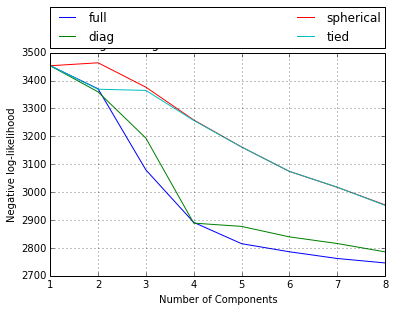

In [7]:
# Analyse models based on the validation data set
models_neg_sum_loglike = numpy.zeros((len(num_comps), len(covariance_types)))

for cov_type_idx in range(len(covariance_types)):
    for num_comp_idx in range(len(num_comps)):
        sum_neg_loglike = -sum( models[cov_type_idx][num_comp_idx].score(X_val) )
        models_neg_sum_loglike[num_comp_idx, cov_type_idx] = sum_neg_loglike
        
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(num_comps, models_neg_sum_loglike)
matplotlib.pyplot.legend(covariance_types, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.title('Negative log-likelihood for the Validation Set')
matplotlib.pyplot.ylabel('Negative log-likelihood')
matplotlib.pyplot.xlabel('Number of Components')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

We can also analyse the BIC for each model, obtained from the validation data.

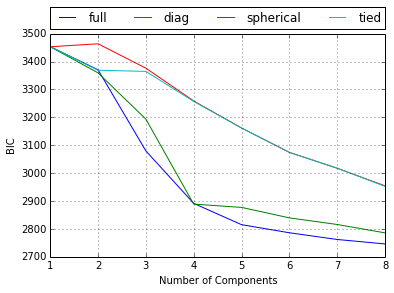

In [8]:
# Analyse models based on the validation data set
models_bic = numpy.zeros((len(num_comps), len(covariance_types)))

for cov_type_idx in range(len(covariance_types)):
    for num_comp_idx in range(len(num_comps)):
        bic = models[cov_type_idx][num_comp_idx].bic(X_val)
        models_bic[num_comp_idx, cov_type_idx] = bic
        
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(num_comps, models_neg_sum_loglike)
matplotlib.pyplot.legend(covariance_types, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)
matplotlib.pyplot.title('BIC')
matplotlib.pyplot.ylabel('BIC')
matplotlib.pyplot.xlabel('Number of Components')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

The best model is selected via its performance against the validation data set.

In [9]:
# Selecting the best model
best_num_comp, best_cov = numpy.where(models_bic == models_bic.min())
best_model = models[best_cov[0]][best_num_comp[0]]
print 'The best model has {} components and {} covariance.'.format(num_comps[best_num_comp[0]], covariance_types[best_cov[0]])

The best model has 7 components and full covariance.


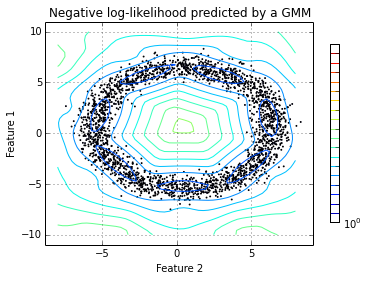

In [10]:
# Display predicted scores by the model as a contour plot
x = numpy.linspace(-8.0, 8.0)
y = numpy.linspace(-10.0, 10.0)
X, Y = numpy.meshgrid(x, y)
XX = numpy.array([X.ravel(), Y.ravel()]).T
Z = -best_model.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = matplotlib.pyplot.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=numpy.logspace(0, 3, 20))
CB = matplotlib.pyplot.colorbar(CS, shrink=0.8, extend='both')
matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1], .8)
matplotlib.pyplot.title('Negative log-likelihood predicted by a GMM')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

The threshold via Monte Carlo is 7.60147978595


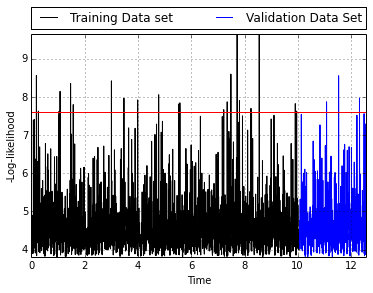

In [11]:
# Statistical monitoring
N_sample = 10000
confidence = 0.99
best_model_sample = best_model.sample(N_sample)
logprob_sample, responsability_sample = best_model.score_samples(best_model_sample)
sorted_logprob_sample = numpy.sort(logprob_sample)
threshold = sorted_logprob_sample[int(numpy.round(N_sample*(1-confidence)))]
print 'The threshold via Monte Carlo is {}'.format(-threshold)

logprob_train, responsability_train = best_model.score_samples(X_train)
logprob_val, responsability_val = best_model.score_samples(X_val)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(t_train, -logprob_train, color = 'black')
matplotlib.pyplot.plot(t_val, -logprob_val, color = 'blue')
matplotlib.pyplot.plot((t_train[0], t_val[-1]), (-threshold, -threshold), color = 'red')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.legend(['Training Data set', 'Validation Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.ylabel('-Log-likelihood')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

In [12]:
out_train = numpy.sum(-logprob_train > -threshold)
print '{} samples from training data is out of control. That represents {} of the data.'.format(out_train, float(out_train)/float(len(logprob_train))*100)
out_val = numpy.sum(-logprob_val > -threshold)
print '{} samples from validation data is out of control. That represents {} of the data.'.format(out_val, float(out_val)/float(len(logprob_val))*100)

22 samples from training data is out of control. That represents 0.916666666667 of the data.
3 samples from validation data is out of control. That represents 0.5 of the data.


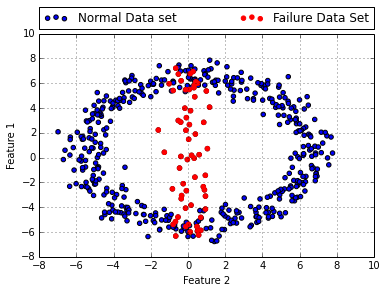

In [13]:
# Create the test data
N_test = 500 # number of data points
t_test = numpy.linspace(0, 4*numpy.pi, N_test)
fail_idxs = numpy.arange(220, 280)
feature1_test = 6.0*numpy.sin(8*t_test+0.001) + 0.5 + 0.6*numpy.random.randn(N_test) # create artificial data with noise
feature2_test = 6.0*numpy.cos(8*t_test+0.001) + 0.5 + 0.6*numpy.random.randn(N_test) # create artificial data with noise
feature1_test[fail_idxs] = 0.6*numpy.random.randn(N_test)
X_test = numpy.vstack((feature1_test, feature2_test)).T

matplotlib.pyplot.figure()
matplotlib.pyplot.scatter(X_test[:, 0], X_test[:, 1])
matplotlib.pyplot.scatter(X_test[fail_idxs, 0], X_test[fail_idxs, 1], color='red')
matplotlib.pyplot.legend(['Normal Data set', 'Failure Data Set'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
matplotlib.pyplot.title('Data set')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

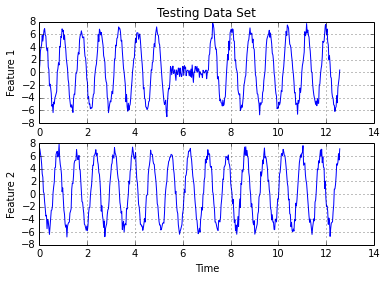

In [14]:
matplotlib.pyplot.figure()
matplotlib.pyplot.subplot(211)
matplotlib.pyplot.plot(t_test, X_test[:, 0])
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.title('Testing Data Set')
matplotlib.pyplot.grid()
matplotlib.pyplot.subplot(212)
matplotlib.pyplot.plot(t_test, X_test[:, 1])
matplotlib.pyplot.ylabel('Feature 2')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

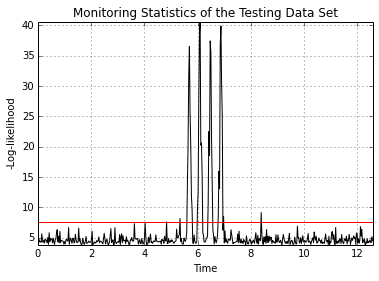

In [15]:
logprob_test, responsability_test = best_model.score_samples(X_test)

matplotlib.pyplot.figure()
matplotlib.pyplot.plot(t_test, -logprob_test, color = 'black')
matplotlib.pyplot.plot((t_train[0], t_val[-1]), (-threshold, -threshold), color = 'red')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.title('Monitoring Statistics of the Testing Data Set')
matplotlib.pyplot.ylabel('-Log-likelihood')
matplotlib.pyplot.xlabel('Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()

In [16]:
out_test = numpy.sum(-logprob_test > -threshold)
print '{} samples from testing data is out of control. That represents {} of the data.'.format(out_test, float(out_test)/float(len(logprob_test))*100)

34 samples from testing data is out of control. That represents 6.8 of the data.


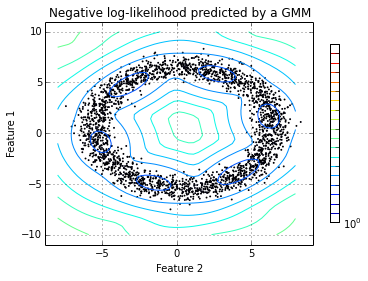

In [17]:
model_mppca = mixture.MPPCA(n_components = 6)
model_mppca.fit(X_train)

# Display predicted scores by the model as a contour plot
x = numpy.linspace(-8.0, 8.0)
y = numpy.linspace(-10.0, 10.0)
X, Y = numpy.meshgrid(x, y)
XX = numpy.array([X.ravel(), Y.ravel()]).T
Z = -model_mppca.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = matplotlib.pyplot.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=numpy.logspace(0, 3, 20))
CB = matplotlib.pyplot.colorbar(CS, shrink=0.8, extend='both')
matplotlib.pyplot.scatter(X_train[:, 0], X_train[:, 1], .8)
matplotlib.pyplot.title('Negative log-likelihood predicted by a GMM')
matplotlib.pyplot.axis('tight')
matplotlib.pyplot.ylabel('Feature 1')
matplotlib.pyplot.xlabel('Feature 2')
matplotlib.pyplot.grid()
matplotlib.pyplot.show()